References:
- https://magazine.sebastianraschka.com/p/building-llms-from-the-ground-up
- https://www.youtube.com/watch?v=quh7z1q7-uc&t=1s
- https://github.com/rasbt/LLM-workshop-2024/tree/main

In [1]:
# Actual Values of GPT-2 "Large" provided
TRIAL_CONFIG_PARAMS = {
    "context_length": 9, # Context Length supported by the model; Actual value: 1024
    "drop_rate" : 0.0,  # Keeping it zero. Can be tried with smaller prob number
    "emb_dim": 10,  # Dimension of Embedding to be created; Actual value: 1280
    "n_heads": 2,  # Number of heads in Multi-Head Attention; Actual value: 20
    "n_layers": 3,  # Number of times Transformer block is repeated; Actual value: 36
    "qvbias": False,  # Skipping bias terms to make the transformers training faster
    "vocab_size": 50257,  # Size of gpt2 tokenizer used

}

In [2]:
import tiktoken
import torch
import torch.nn as nn

/Users/sharmilisrinivasan/miniconda3/envs/llm_from_scratch_py312/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


## Helpers

### 1. Helper Functions

In [3]:
def print_shape(step_name, shape, level=0):
    print(f"{"  "*level}Shape of output from {step_name} is {shape}")

### 2. Helper NN Layers

#### 2.1. Layer Norm
- Normalise features within a layer (not across batch)
- Mean and variance are calculated for all activations in a layer
- These are scaled and shifted to have standard normal distribution (mean=0; variance=1)
- Handles problems of Internal covariate shift

_Terminologies_
1. Activations = Outputs of the neurons
2. Internal covariate shift = During training as each layer takes inputs from previuous layers and the input distribution keeps changing as each layer is learning. This leads to slow converges

_Formula_

```output = [scale * (input - mean)/ sqrt(variance + epsilon)] + shift```
* mean = mean across activations
* variance = (Std_dev)^2 = Variance across activations
* epsilon = small constant to avoid division by zero
* scale, shift = learnable parameters


In [4]:
class LayerNorm(nn.Module):
    def __init__(self, out_dim, print_level=0):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(out_dim))  # Of type torch.Size([out_dim])
        self.shift = nn.Parameter(torch.zeros(out_dim)) # Of type torch.Size([out_dim])
        self.print_level = print_level

    def forward(self, in_data):
        print(f"{"  "*self.print_level}======= Beginning Layer Normalisation =======")

        # 1. Mean
        # Out Shape: <in_dim...> * 1
        mean = in_data.mean(dim=-1, keepdim=True)  # Dim=-1 => Along last layer; keep_dim retains dimension. Else, reduces #dim by 1
        print_shape("Mean", mean.shape, self.print_level)

        # 2. Variance
        # Out Shape: <in_dim...> * 1
        var = in_data.var(dim=-1, keepdim=True, unbiased=False)  # Turning off Unbiased avoids division by zero
        print_shape("Variance", var.shape, self.print_level)

        # 3. Normalisation
        # Out Shape: <same as in_data>
        norm_in_data = (in_data - mean)/torch.sqrt(var + self.epsilon)
        print_shape("Normalisation", norm_in_data.shape, self.print_level)

        # 4. Final Output
        # Out Shape: <same as in_data>
        final_norm = (self.scale * norm_in_data) + self.shift
        print_shape("Final Normalised output", final_norm.shape, self.print_level)

        print(f"{"  "*self.print_level}======= Completed Layer Normalisation =======")

        return final_norm


#### 2.2. GELU
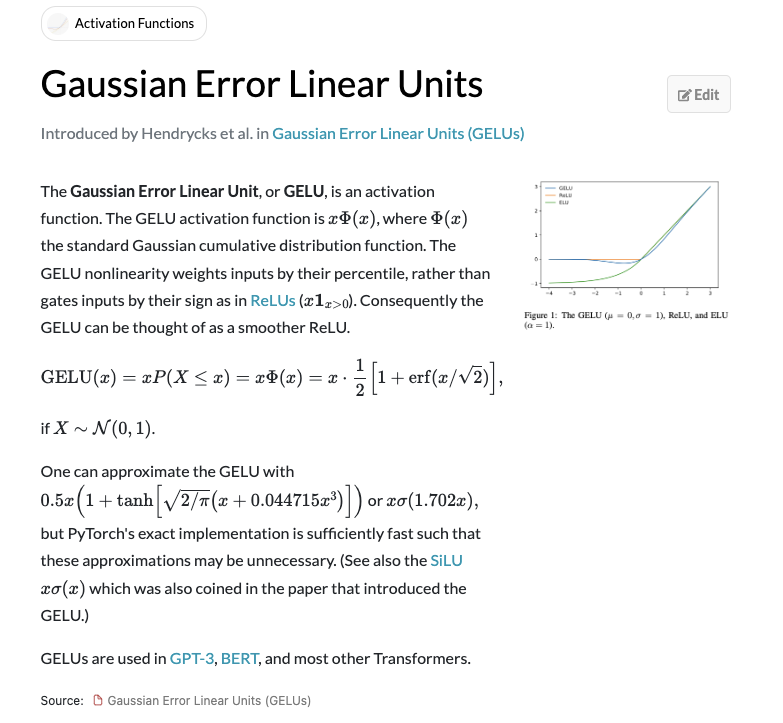

In [5]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, in_tensor):
        gelu = lambda x : (0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3)))))
        return gelu(in_tensor)

#### 2.3. Feed Forward
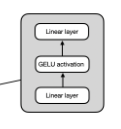

In [6]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        emb_dim = config["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim),
            GELU(),
            nn.Linear(4*emb_dim, emb_dim)
        )

    def forward(self, in_data):
        #  In Shape: batch_size * in_seq_len * emb_dim

        #  -1. For formating prints
        print_level = 3
        print(f"{"  "*print_level}!!!!!!!!!!!!!!!! Beginning Feed Forward !!!!!!!!!!!!!!!!")
        
        #  1. Feed Forward
        #  Linear -> GELU -> Linear
        #  Out Shape: batch_size * in_seq_len * emb_dim 
        output = self.layers(in_data)
        print_shape("Feed Forward", output.shape, print_level)
        
        print(f"{"  "*print_level}!!!!!!!!!!!!!!!! Completed Feed Forward !!!!!!!!!!!!!!!!")
        return in_data

## Complete E2E Flow
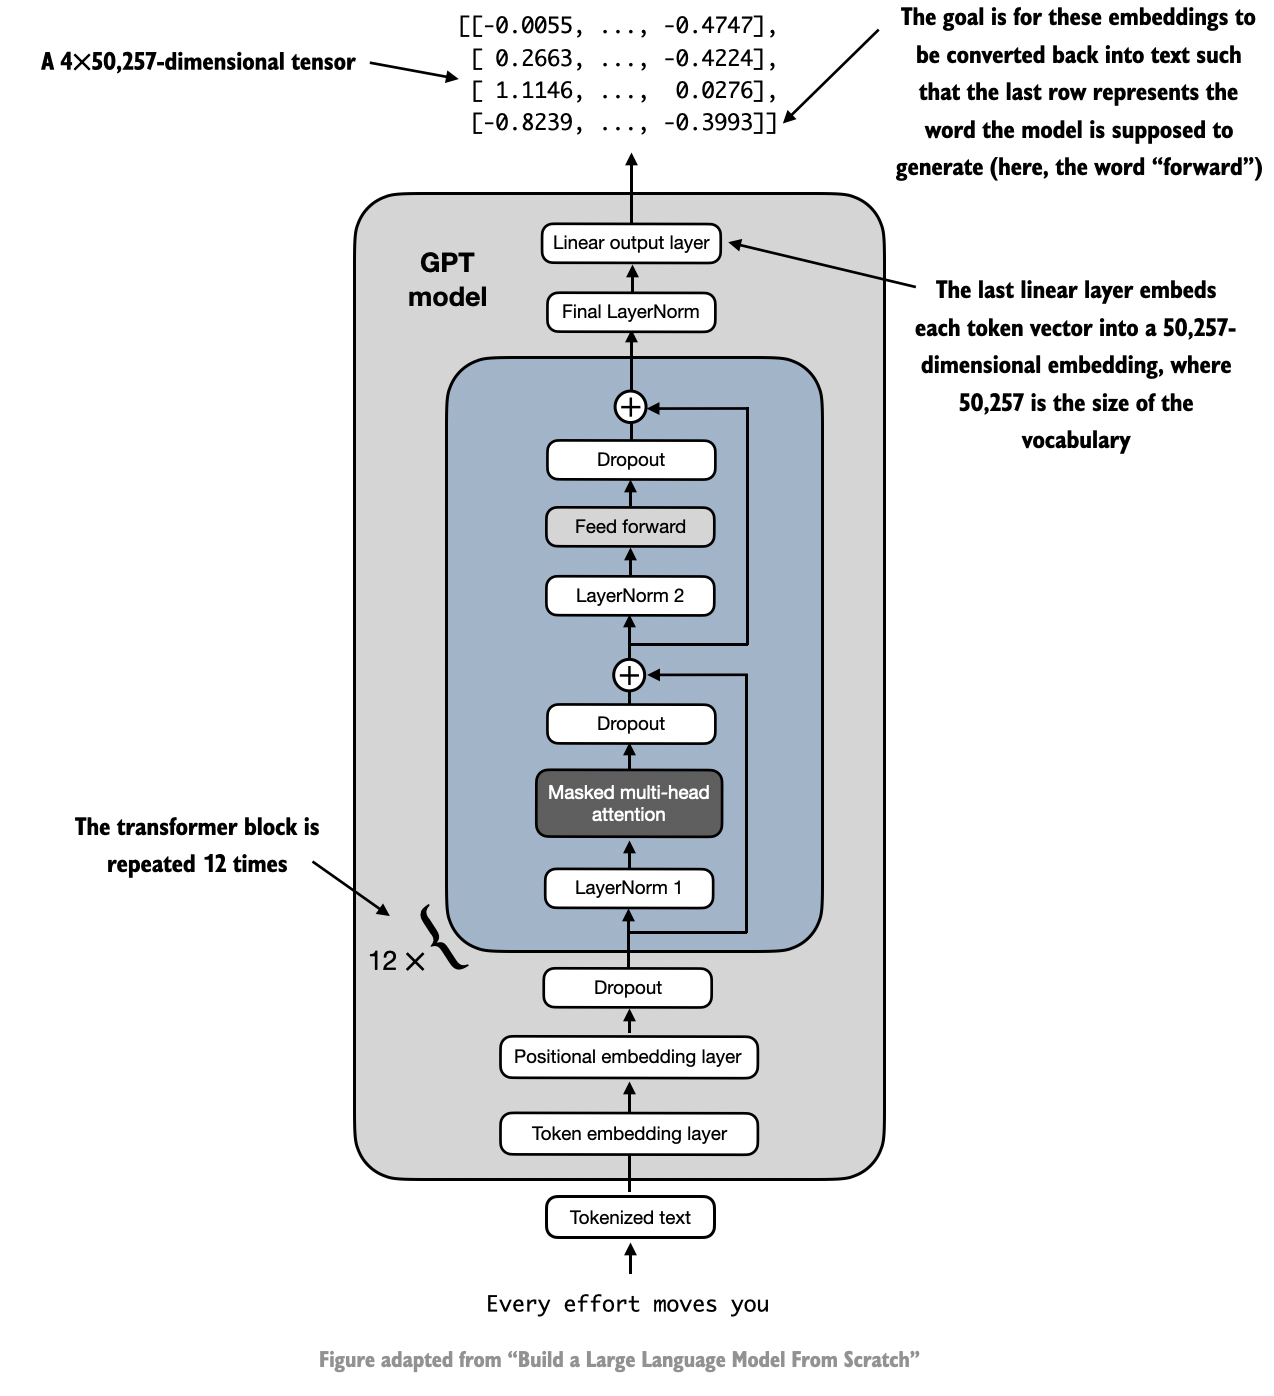

### 1. Masked Multi-Head Attention

Reference Architechture: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

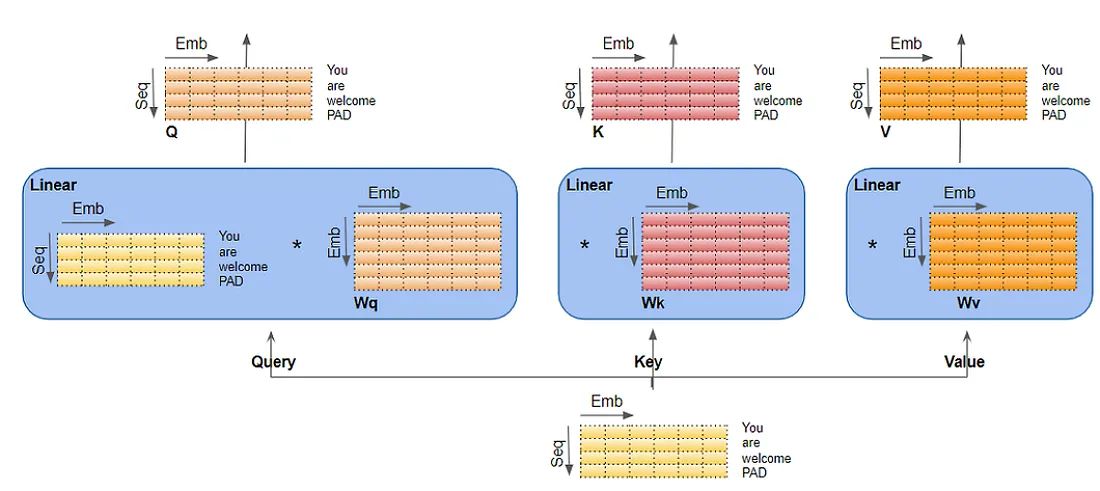

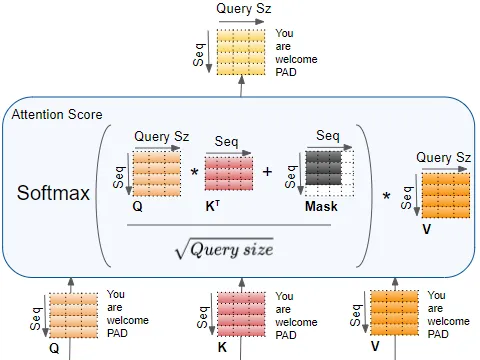

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        #  Extract required fiedls from the config
        context_length = config["context_length"]
        self.emb_dim = config["emb_dim"]
        self.n_heads = config["n_heads"]
        qvbias = config["qvbias"]

        #  Linear Transformations with Weight Matrices
        #  Shapes for all Weight Matrices: emb_dim * emb_dim
        self.linear_query = nn.Linear(self.emb_dim, self.emb_dim, qvbias)
        self.linear_key = nn.Linear(self.emb_dim, self.emb_dim, qvbias)
        self.linear_value = nn.Linear(self.emb_dim, self.emb_dim, qvbias)

        #  Multi Head Prep
        assert self.emb_dim % self.n_heads == 0, "emb_dim must be divisible by n_heads"
        self.head_dim = self.emb_dim // self.n_heads  # Splitting emb_dim across all heads equally

        #  Mask Prep
        #  Upper Triangle with ones of context length is created; 
        #  Primary diagonal and below are marked zeros. 
        #  Note: 
        #  - diagonal=1 implies consider from one above primary diagonal; 
        #  - 0 will imply to include primary diagonal; 
        #  - -X will imply to consider X diagonals below primary diagonal
        #  Shape of Mask: context_length * context_length
        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        #  Note regarding register buffer: 
        #  If you have parameters in your model, which should be saved and restored in the state_dict,
        #  but not trained by the optimizer, you should register them as buffers.
        #  Buffers won’t be returned in model.parameters(),
        # so that the optimizer won’t have a change to update them.
        self.register_buffer("mask", mask)

        # Dropout
        self.dropout = nn.Dropout(config["drop_rate"])

        # Linear Layer for out projection (optional)
        self.out_proj_linear = nn.Linear(self.emb_dim, self.emb_dim)



    def forward(self, in_data):
        #  In Shape: batch_size * in_seq_len * emb_dim

        #  -1. For formating prints
        print_level = 3
        print(f"{"  "*print_level}!!!!!!!!!!!!!!!! Beginning Multi Head Attention !!!!!!!!!!!!!!!!")

        #  0. Extracting dimension shapes from incoming data
        batch_size, in_seq_len, _ = in_data.shape

        #  1. Linear Layers
        #  Out Shape for all 3: batch_size * in_seq_len * emb_dim
        queries = self.linear_query(in_data)
        keys= self.linear_key(in_data)
        values = self.linear_value(in_data)
        print_shape("Linear Transformation of Queries", queries.shape, print_level)
        print_shape("Linear Transformation of Keys", keys.shape, print_level)
        print_shape("Linear Transformation of Values", values.shape, print_level)

        #  2. Split Embeddings into Multi-Heads
        #  We implicitly split the matrix by adding a `n_heads` dimension
        #  Unroll last dim: 
        #  (batch_size, in_seq_len, emb_dim) -> (batch_size, in_seq_len, n_heads, head_dim)
        #  Out Shape for all 3: batch_size * in_seq_len * n_heads * head_dim
        queries = queries.view(batch_size, in_seq_len, self.n_heads, self.head_dim)
        keys = keys.view(batch_size, in_seq_len, self.n_heads, self.head_dim)
        values = values.view(batch_size, in_seq_len, self.n_heads, self.head_dim)
        print_shape("Queries - Split to Multi Head", queries.shape, print_level)
        print_shape("Keys - Split to Multi Head", keys.shape, print_level)
        print_shape("Values - Split to Multi Head", values.shape, print_level)

        #  3. Transpose for further computation
        #  Out Shape for all 3: batch_size * n_heads * in_seq_len * head_dim
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        print_shape("Queries - Transposed", queries.shape, print_level)
        print_shape("Keys - Transposed", keys.shape, print_level)
        print_shape("Values - Transposed", values.shape, print_level)

        #  4. Scaled Self Attention with mask
        #  Out Shape: batch_size * num_heads * in_seq_len * in_seq_len

        ##  4.1. Self Attention (dot-product) at each head
        ##  Output = Q . KT
        ##  Out Shape: batch_size * num_heads * in_seq_len * in_seq_len
        keys_transpose = keys.transpose(2, 3)  # Transposing in_seq_len & head_dim => For output to be in_seq_len by in_seq_len per head
        self_attention_scores = queries @ keys_transpose
        print_shape("Self Attention", self_attention_scores.shape, print_level)

        ##  4.2. Preping the mask & Masking
        ##  Masking is used in "decoder" architecture to stop model from seeing into future information during training.
        mask_bool = self.mask.bool()[:in_seq_len, :in_seq_len]  # Original mask truncated to the in_seq_len and converted to boolean
        print(f"{"  "*print_level}Mask Matrix is: {mask_bool}")
        self_attention_scores.masked_fill_(mask_bool, -torch.inf)  # Use Mask and fill masked areas with "-inf"
        print_shape("Masked Self Attention", self_attention_scores.shape, print_level)  # Shape is maintained - Only Upper triangle is masked to inf

        ##  4.3. Scaling the Self Attention
        ##  https://paperswithcode.com/method/scaled
        ##  Scaled dot-product attention is an attention mechanism where the dot products are scaled down by sqrt(dk)
        denominator = keys.shape[-1] ** 0.5  # Get number of elements per head and take square root for denominator of scaling
        scaled_self_attention_scores = self_attention_scores / denominator  # scaled value = self_attention_scores / sq_root(#dim per head)
        print_shape("Scaled Masked Self Attention", scaled_self_attention_scores.shape, print_level)

        #  5. Attention Weights
        #  dropout(softmax(Scaled Attention Scores)) * values
        #  Out Shape: batch_size * num_heads * in_seq_len * head_dim
        softmax_scaled_self_attention_scores = torch.softmax(scaled_self_attention_scores, dim=-1)  # Softmax
        dropout_softmax_scaled_self_attention_scores = self.dropout(softmax_scaled_self_attention_scores)  # Dropout
        attention_weights = dropout_softmax_scaled_self_attention_scores @ values  # Dot product
        print_shape("Attention Weights", attention_weights.shape, print_level)

        #  6. Reshapes
        #  Out Shape: batch_size * in_seq_len * emb_dim
        context_vector = attention_weights.transpose(1,2)  # Reverse Swap of heads and in_seq_len
        print_shape("Reverse Swap", context_vector.shape, print_level)
        ## Note for context_vector.contiguous:
        ## Makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.
        context_vector = context_vector.contiguous().view(batch_size, in_seq_len, self.emb_dim)  # Merge heads To form batch_size * in_seq_len * original emb_dim
        print_shape("Final Reshapes", context_vector.shape, print_level)

        #  7. Optional Linear projection
        #  Out Shape: batch_size * in_seq_len * emb_dim
        context_vector_to_return = self.out_proj_linear(context_vector)
        print_shape("Masked Multi Head Attention", context_vector_to_return.shape, print_level)

        print(f"{"  "*print_level}!!!!!!!!!!!!!!!! Completed Multi Head Attention !!!!!!!!!!!!!!!!")
        return in_data

### 2. Transformer Block
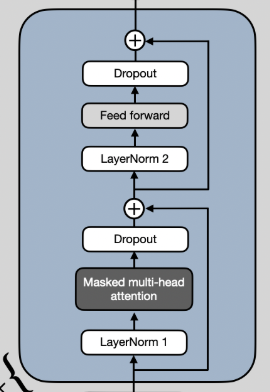

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.norm_1 = LayerNorm(config["emb_dim"], print_level=3)
        self.multi_head_attention = MultiHeadAttention(config)
        self.drop_out = nn.Dropout(config["drop_rate"])
        self.norm_2 = LayerNorm(config["emb_dim"], print_level=3)
        self.feed_forward = FeedForward(config)


    def forward(self, in_data):
        #  In Shape: batch_size * in_seq_len * emb_dim

        #  -1. For formating prints
        print_level = 2
        print(f"{"  "*print_level}@@@@@@@@@@@@ Beginning Transformer Block @@@@@@@@@@@@")

        #  0.0 Save shortcut to add later
        shortcut = in_data

        #  1. First Norm Layer
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.norm_1(in_data)
        print_shape("First Layer Norm", processed_data.shape, print_level)

        #  2. Maksed Multi Head Attention
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.multi_head_attention(processed_data)
        print_shape("Masked Multi Head Attention", processed_data.shape, print_level)

        #  3. First Dropout
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.drop_out(processed_data)
        print_shape("First Dropout", processed_data.shape, print_level)

        #  4. Add Shortcut (Original data back)
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = processed_data + shortcut
        print_shape("Shortcut Addition - Original data", processed_data.shape, print_level)

        #  0.1 Update shortcut to add later
        shortcut = processed_data

        #  5. Second Norm Layer
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.norm_2(processed_data)
        print_shape("Second Layer Norm", processed_data.shape, print_level)

        #  6. Feed Forward
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.feed_forward(processed_data)
        print_shape("Feed Forward", processed_data.shape, print_level)

        #  7. Second Dropout
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.drop_out(processed_data)
        print_shape("Second Dropout", processed_data.shape, print_level)

        #  8. Add Shortcut (Intermediate data back)
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = processed_data + shortcut
        print_shape("Shortcut Addition - Intermediate data", processed_data.shape, print_level)

        print(f"{"  "*print_level}@@@@@@@@@@@@ Completed Transformer Block @@@@@@@@@@@@")

        return processed_data

### 3. Main Driver Model

In [9]:
class TrialGPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])  # Size of vocab dictionary, Size of output vector
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])  # Size of context length (max supported), Size of output vector
        self.drop_emb = nn.Dropout(config["drop_rate"])
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(config) for i in range(config["n_layers"])])  # Repeat Transformer block sequentially n_layer times
        self.final_norm = LayerNorm(config["emb_dim"], print_level=2)
        self.linear_out = nn.Linear(config["emb_dim"], config["vocab_size"])

    def embedding_layers(self, batch, in_seq_len):
       #  0. For formating prints
        print_level = 2
        print(f"{"  "*print_level}======= Beginning Embedding =======")

        # 1. Token Embedding
        # Maps each token of each data in input batch to size of output vector
        # Out Shape: batch_size * in_seq_len * emb_dim
        tok_embeds = self.tok_emb(batch)
        print_shape("Token Embedding Layer", tok_embeds.shape, print_level)

        # 2. Positional Embedding
        # Maps each position of each data in input batch to size of output vector
        # Out Shape: in_seq_len * emb_dim
        pos_ids = torch.arange(in_seq_len, device=batch.device)  # Creating tensor of positional ids
        pos_embeds = self.pos_emb(pos_ids)
        print_shape("Positional Embedding Layer", pos_embeds.shape, print_level)

        # 3. Final Embedding
        # Token Embedding + Positional Embedding
        # Out Shape: batch_size * in_seq_len * emb_dim
        final_embedding = tok_embeds + pos_embeds
        print_shape("Final Embedding Layer", final_embedding.shape, print_level)

        print(f"{"  "*print_level}======= Completed Embedding =======")

        return final_embedding

    
    def forward(self, batch_tokenized_data):

        #  -1. For formating prints
        print_level = 1

        #  0. Input
        #  Shape of Incoming batch data: batch_size * in_seq_len
        batch_size, in_seq_len = batch_tokenized_data.shape

        #  1. Embedding Layers (Token and position)
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.embedding_layers(batch_tokenized_data, in_seq_len)
        print_shape("Embedding Layers", processed_data.shape, print_level)

        #   2. Dropout
        #   Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.drop_emb(processed_data)
        print_shape("Dropout Layer on Embedding", processed_data.shape, print_level)

        #  3. Transformer Block
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.transformer_blocks(processed_data)
        print_shape("Sequential Transformer Blocks", processed_data.shape, print_level)
        
        #  4. Final Norm Layer
        #  Out Shape: batch_size * in_seq_len * emb_dim
        processed_data = self.final_norm(processed_data)
        print_shape("Final Norm Layer", processed_data.shape, print_level)

        #  5. Linear Output Layer
        #  Embeds every token vector of "emb_dim" length to a dimensional space of "vocab_size"
        #  Out Shape: batch_size * in_seq_len * vocab_size
        logits = self.linear_out(processed_data)
        print_shape("Final Logits", logits.shape, print_level)

        return logits

## Inferencing Helpers
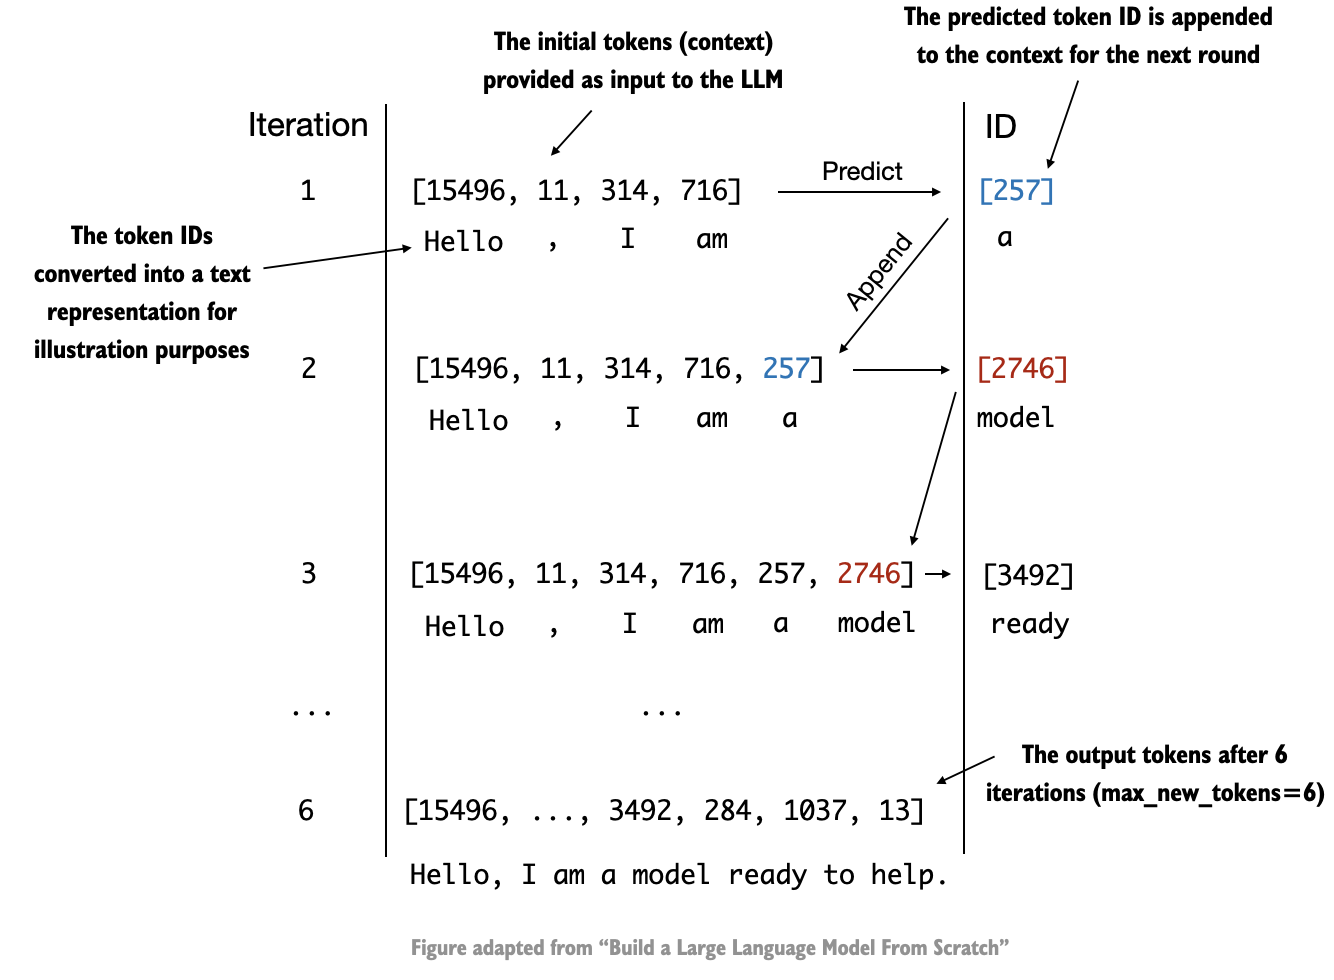

In [10]:
def generate_text(model, in_data, max_tokens_to_generate, context_size):
    #  model: Model to use
    #  in_data: Tokenized data on shape batch_size * in_seq_len (Note: in_seq_len might be > context_size)
    #  max_tokens_to_generate: Number of tokens/words to generate
    #  context_size: Max context size supported by the model

    for iter_cnt in range(max_tokens_to_generate):

        print("\n")
        print(f"*********************** Generating {iter_cnt+1} word ***********************")

        #  1. Truncate incoming batch to context length as model cannot process beyond this
        #  Note: Last X tokens are taken: *NOT* first X words
        #  Out Shape: batch_size * context_length
        in_data = in_data[:, -context_size:]
        print_shape("Truncated input", in_data.shape)

        #  2. Get predictions from model
        #  Out Shape: batch_size * context_length * vocab_size
        with torch.no_grad():  # No gradient descent and back prop during inferencing
            logits = model(in_data)
        print_shape("Inferencing from model", logits.shape)

        #  3. Consider only the last step
        #  Out Shape: batch_size * vocab_size
        logits = logits[:, -1, :]
        print_shape("Filtering for last step", logits.shape)

        #  4. Softmax for probabilities
        #  Out Shape: batch_size * vocab_size
        probas = torch.softmax(logits, dim=-1)  # On vocab dimension (dim=-1)
        print_shape("Softmax", logits.shape)

        #   5. Get index of highest probability
        #   Out Shape: batch_size * 1
        index_to_add = torch.argmax(probas, dim=-1, keepdim=True)
        print_shape("Pick Highest Prob Index", index_to_add.shape)

        #  6. Append to data for next batch iteration
        #  Out Shape: batch_size * in_seq_len + 1
        in_data = torch.cat((in_data, index_to_add), dim=1)  # Add to the column of 2D => dim=1
        print_shape("Next batch Size", in_data.shape)

    return in_data


In [11]:
class TokenizerHelper():
    def __init__(self):
        self.tokenizer = tiktoken.get_encoding("gpt2")

    def tokenize_batch(self, in_batch, max_in_seq_len):
        #  in_batch is list of strings
        #  out_batch is Tensor list of Tensors of token_ids

        out_batch = []

        for in_str in in_batch:
            # For Each String,
            # 1. Encode using tokenizer
            # 2. Convert to Tensor
            # 3. Resize to max_in_seq_len: All inputs to be of same length = Either truncated or padded with 0s
            out_batch.append(torch.tensor(self.tokenizer.encode(in_str)).resize_(max_in_seq_len))

        return torch.stack(out_batch, dim=0)

    def detokenize_batch(self, in_batch):
        #  in_batch is Tensor list of Tensors of token_ids
        #  out_batch is list of strings
        out_batch = []

        for data in in_batch:
            out_batch.append(self.tokenizer.decode(data.tolist()))

        return out_batch

## Sample Inferencing

In [12]:
#  0. Sample Inputs
in_seq_len = 7
txt1 = "Every effort moves you towards your goal"  # Text with token_len=in_seq_len
txt2 = "Every day holds a"  # Text with token_len<in_seq_len
txt3 = "This statement is going to have token length greater than input sequence length"  # Text with token_len>in_seq_len
in_strings = [txt1, txt2, txt3]

In [13]:
tokenizer_helper = TokenizerHelper()

In [14]:
#  1. Tokenize - Convert words to token IDs
tokenized_in_strings = tokenizer_helper.tokenize_batch(in_strings, in_seq_len)
print_shape("Tokenization", tokenized_in_strings.shape)

Shape of output from Tokenization is torch.Size([3, 7])


In [15]:
#  2. Generate output with the model
trial_gpt_model = TrialGPTModel(TRIAL_CONFIG_PARAMS)
output_tokens = generate_text(trial_gpt_model, tokenized_in_strings, 1, TRIAL_CONFIG_PARAMS["context_length"])



*********************** Generating 1 word ***********************
Shape of output from Truncated input is torch.Size([3, 7])
    ======= Beginning Embedding =======
    Shape of output from Token Embedding Layer is torch.Size([3, 7, 10])
    Shape of output from Positional Embedding Layer is torch.Size([7, 10])
    Shape of output from Final Embedding Layer is torch.Size([3, 7, 10])
    ======= Completed Embedding =======
  Shape of output from Embedding Layers is torch.Size([3, 7, 10])
  Shape of output from Dropout Layer on Embedding is torch.Size([3, 7, 10])
    @@@@@@@@@@@@ Beginning Transformer Block @@@@@@@@@@@@
      ======= Beginning Layer Normalisation =======
      Shape of output from Mean is torch.Size([3, 7, 1])
      Shape of output from Variance is torch.Size([3, 7, 1])
      Shape of output from Normalisation is torch.Size([3, 7, 10])
      Shape of output from Final Normalised output is torch.Size([3, 7, 10])
      ======= Completed Layer Normalisation =======
    Sh

In [16]:
#  3. Detokenize - Convert Token IDs to Words
output = tokenizer_helper.detokenize_batch(output_tokens)
print_shape("E2E Run", len(output))
print("\n")
print("\n".join(output))

Shape of output from E2E Run is 3


Every effort moves you towards your goalmeet
Every day holds a!!!secure
This statement is going to have tokenNYSE
